In [1]:
import pandas as pd
import numpy as np

### The input data

In [2]:
X_train = np.load('data/Data_train/data_train.npy', mmap_mode='r')

print("The training data is made of {} images of {}x{} pixels".format(
    *X_train.shape))

n_img = len(X_train)

The training data is made of 619 images of 400x400 pixels


In [3]:
df = pd.read_csv('data/Data_train/data_train_labels.csv')
df.head()

,id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 2 columns):
id       619 non-null int64
label    619 non-null int64
dtypes: int64(2)
memory usage: 9.8 KB


The labels consist of a `pandas.DataFrame` containing for each row :
- `id` : the unique identifier of the image
- `label` : the class to which belongs the observed nevus :
    - `1 : benign`
    - `2 : unknown` 
    - `3 : malignant`

In [5]:
df['label'].value_counts().sort_index().plot.bar(figsize=(12, 6))

labels = ['Benign','Unknown','Malignant']

labels_count_df = df.groupby(['label']).agg('count').reset_index()
labels_count_df['name'] = pd.Series(data=labels)
labels_count_df.columns = ['Label','Count','Name']
labels_count_df

,Label,Count,Name
0,1,324,Benign
1,2,137,Unknown
2,3,158,Malignant


We can analyze the dataset metadata to better understand the labels distribution among the observed population.

In [6]:
meta = pd.read_csv('data/metadata.csv')
meta = meta[['meta.clinical.age_approx', 'meta.clinical.sex', 'meta.clinical.benign_malignant']]
meta.rename({'meta.clinical.age_approx':'age', 'meta.clinical.sex':'sex', 'meta.clinical.benign_malignant':'label'}, axis=1, inplace=True)
meta['label'].loc[meta['label'] != 'benign'] = 'malignant'
meta.head()

C:\Users\Jean\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,age,sex,label
0,55.0,female,benign
1,30.0,female,benign
2,60.0,female,malignant
3,30.0,male,benign
4,80.0,male,malignant


In [7]:
meta.groupby('age').count()[['label']].sort_values(
    'age', ascending=False).reset_index().plot.bar(
    x='age', figsize=(16, 10), fontsize=18);

However, these data are not provided for the current challenge. But the age and sex of a patient could be filled on a mobile app to make the melanoma detection model better.

Here, we display one image for each class.

In [8]:
idx_list = [10, 335, 540]

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

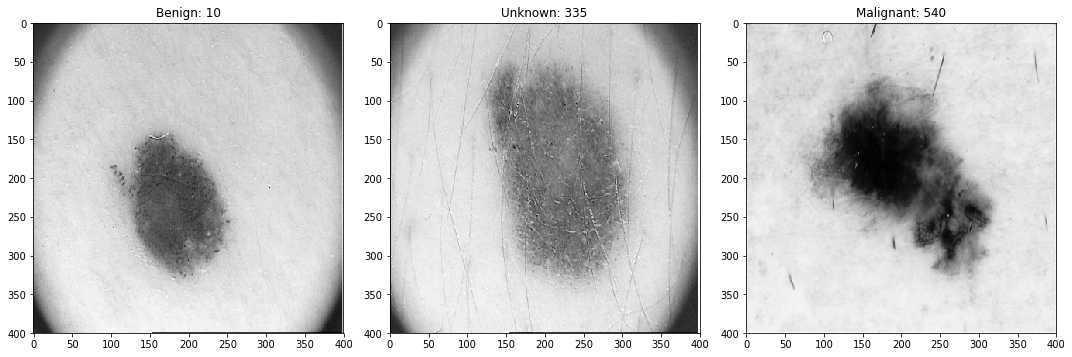

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title(labels[i] + ': %d' % idx)
fig.tight_layout()

### Image preprocessing

As most nevus are in the middle of the image, here we decide to crop the images.

In [11]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

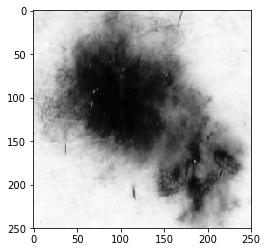

In [13]:
croped_melanoma = crop_center(X_train[540], 250, 250)
plt.imshow(croped_melanoma, cmap='Greys_r')

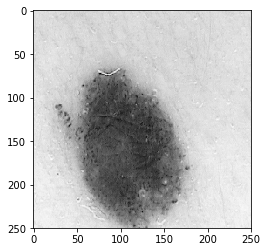

In [40]:
croped_nevus = crop_center(X_train[10], 250, 250)
plt.imshow(croped_nevus, cmap='Greys_r')

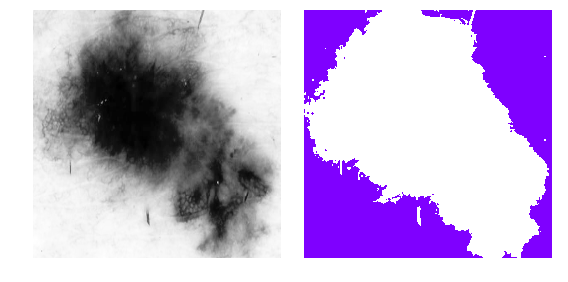

In [51]:
from scipy import ndimage

blobs = (croped_melanoma < 160)
labels, nlabels = ndimage.label(blobs)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5))
ax[0].imshow(croped_melanoma, cmap='Greys_r')
ax[1].imshow(np.ma.masked_array(labels, blobs), cmap=plt.cm.rainbow)

for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.show()

In [52]:
np.sum(blobs)

36459

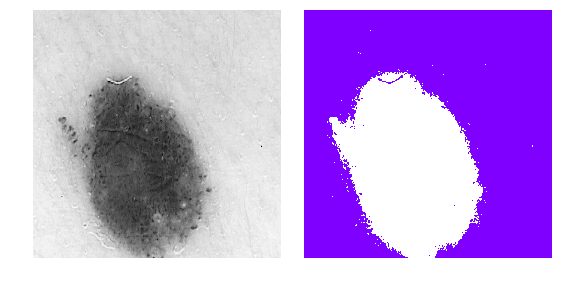

In [49]:
blobs2 = (croped_nevus < 160)
labels2, nlabels = ndimage.label(blobs2)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5))
ax[0].imshow(croped_nevus, cmap='Greys_r')
ax[1].imshow(np.ma.masked_array(labels2, blobs2), cmap=plt.cm.rainbow)

for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.show()

In [50]:
np.sum(blobs2)

19034

Mesure de l'irrégularité de la forme

im = imread(input_image_path);
bw = im2bw(im);

%// Parameter for cutting into four slices into the third dimsensions 
%// corresponding to the four objects
common_width = 270; 

%// Threshold to decide between regular and irregular ones
factor1_th = 0.01;

bw1 = bw(:,1:common_width*floor(size(bw,2)/common_width)); %// Cropped image
objs =reshape(bw1,size(bw1,1),common_width,[]);%//Objects stored as dim3 slices
for objc=1:size(objs,3) %// Object counter
    disp(['-------------- Processing Obj #' num2str(objc)]);
    obj = objs(:,:,objc);
    corners = corner(obj);
    factor1 = size(corners,1)/nnz(obj)
    if factor1 > factor1_th
        disp('This is an irregular one.'); %//'
    else
        disp('This is a regular one.'); %//'
    end
end